<a href="https://colab.research.google.com/github/MayoMathur/SingleLayerFF-/blob/main/tanh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
from torch import reshape
from torchvision.transforms import ToTensor
from torchvision import  datasets
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


In [2]:
train_set = datasets.MNIST('data', train= True, download=True, transform=ToTensor())
test_set = datasets.MNIST('data', train=False, download=True, transform=ToTensor())
print(len(train_set))
print(len(test_set))

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!
60000
10000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(train_set, [50000, 10000])
print(len(train_ds), len(val_ds))

batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_d = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory= True)
test_dl = DataLoader(test_set, batch_size)

for X, Y in train_dl:
  print("Shape of X[N, C, H, W]", X.shape)
  print("Shape of y: ", Y.shape, Y.dtype)
  break


50000 10000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Shape of X[N, C, H, W] torch.Size([128, 1, 28, 28])
Shape of y:  torch.Size([128]) torch.int64


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Images:  torch.Size([128, 1, 28, 28])


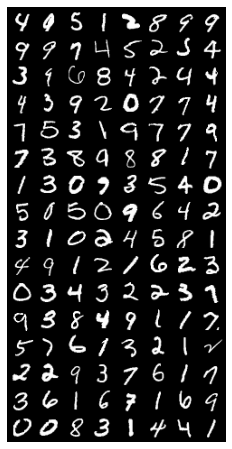

In [4]:
for images, _ in train_dl:
    print('Images: ', images.shape)
    plt.figure(figsize=(10,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute(1, 2, 0)) 
    break

In [5]:
def accuracy(output, labels):
    _, predict = torch.max(output, dim=1)
    return torch.tensor(torch.sum(predict == labels).item()/ len(predict) )

In [39]:
input_size= 28*28
classes = 10

class MNISTModel(nn.Module):
  def __init__(self):
    super(MNISTModel, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(input_size, 512),
        nn.Tanh(),        
        nn.Linear(512, classes),
        # nn.ReLU()
    )
  def forward(self, x):
    x = self.flatten(x)
    # x = nn.Softmax(dim=1)
    out = self.linear_relu_stack(x)
    # out = nn.Softmax(out, dim=1)
    return out 

  def train_set(self, batch):
    imgs, labels =  batch
    out = self(imgs)
    loss = cross_entropy(out, labels )
    return loss
  
  # def accuracy(self, output, labels):
  #   _, predict = torch.max(self.output, dim=1)
  #   return torch.tensor(torch.sum(predict == self.labels).item()/ len(predict) )

  def val_set(self, batch):
    imgs, labels =  batch
    out = self(imgs)
    loss = cross_entropy(out, labels )
    acc = accuracy(out, labels)
    return {'val_loss': loss, 'val_acc': acc}

  def val_epoch(self, output):
    batch_losses = [x['val_loss'] for x in output]
    epoch_losses = torch.stack(batch_losses).mean()
    batch_accuracies = [x['val_acc'] for x in output]
    epoch_accuracies = torch.stack(batch_accuracies).mean()
    return {'val_loss':epoch_losses.item(), 'val_acc': epoch_accuracies.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))        

 

model = MNISTModel()
print(model)
print('Model Parameters: ', list(model.parameters())[0].size())
print('Model Parameters: ', list(model.parameters())[1].size())

MNISTModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)
Model Parameters:  torch.Size([512, 784])
Model Parameters:  torch.Size([512])


In [40]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD()

In [41]:
def evaluate(model, val_dl):
    output = [model.val_set(batch) for batch in val_dl]
    return model.val_epoch(output)

In [42]:
def fit(epochs, lr, model, train_dl, val_dl, opt_func=torch.optim.SGD):
    history = []
    predictions_list = []

    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        # Training Phase 
        train_losses = []
        prediction_list = []
        correct = 0
        labels_list = []

        for batch in train_dl:
            
            # outputs = model(batch)

            # predictions = torch.max(outputs, 1)[1]
            # predictions_list.append(predictions)
            # correct += (predictions == labels).sum()
            # im, l = batch
            # labels_list.extend(l)#

            loss = model.train_set(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history #, predictions_list, labels_list

In [43]:
result0 = evaluate(model, val_d)
result0

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.1142578125, 'val_loss': 2.308403491973877}

In [44]:
history1 = fit(5, 0.001, model, train_dl, val_d)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 2.1023, val_acc: 0.5635
Epoch [1], val_loss: 1.9151, val_acc: 0.6859
Epoch [2], val_loss: 1.7368, val_acc: 0.7309
Epoch [3], val_loss: 1.5690, val_acc: 0.7523
Epoch [4], val_loss: 1.4167, val_acc: 0.7689


In [45]:
history2 = fit(5, 0.001, model, train_dl, val_d)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.2832, val_acc: 0.7820
Epoch [1], val_loss: 1.1691, val_acc: 0.7955
Epoch [2], val_loss: 1.0733, val_acc: 0.8097
Epoch [3], val_loss: 0.9929, val_acc: 0.8185
Epoch [4], val_loss: 0.9256, val_acc: 0.8252


In [46]:
history23 = fit(5, 0.001, model, train_dl, val_d)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.8689, val_acc: 0.8325
Epoch [1], val_loss: 0.8207, val_acc: 0.8379
Epoch [2], val_loss: 0.7796, val_acc: 0.8407
Epoch [3], val_loss: 0.7440, val_acc: 0.8456
Epoch [4], val_loss: 0.7131, val_acc: 0.8494


In [47]:
history3 = fit(5, 0.001, model, train_dl, val_d)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.6860, val_acc: 0.8531
Epoch [1], val_loss: 0.6621, val_acc: 0.8555
Epoch [2], val_loss: 0.6408, val_acc: 0.8585
Epoch [3], val_loss: 0.6217, val_acc: 0.8607
Epoch [4], val_loss: 0.6046, val_acc: 0.8628


In [48]:
history4 = fit(5, 0.001, model, train_dl, val_d)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.5892, val_acc: 0.8643
Epoch [1], val_loss: 0.5751, val_acc: 0.8664
Epoch [2], val_loss: 0.5623, val_acc: 0.8670
Epoch [3], val_loss: 0.5506, val_acc: 0.8679
Epoch [4], val_loss: 0.5398, val_acc: 0.8685


In [49]:
history5 = fit(5, 0.001, model, train_dl, val_d)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.5299, val_acc: 0.8703
Epoch [1], val_loss: 0.5207, val_acc: 0.8718
Epoch [2], val_loss: 0.5123, val_acc: 0.8728
Epoch [3], val_loss: 0.5044, val_acc: 0.8736
Epoch [4], val_loss: 0.4969, val_acc: 0.8750


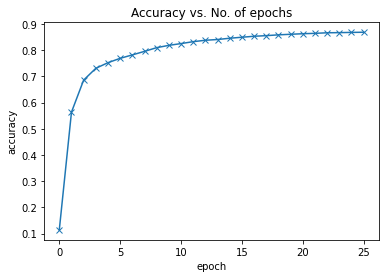

In [50]:

history = [result0] + history1 + history2 + history23 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Text(0.5, 1.0, 'loss vs Accuracy')

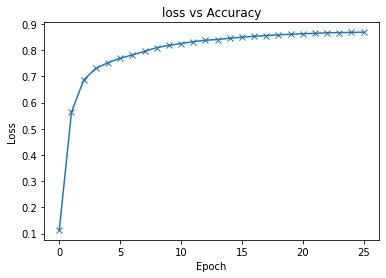

In [51]:
history = [result0] + history1 + history2 + history23 + history3 + history4

accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('loss vs Accuracy')

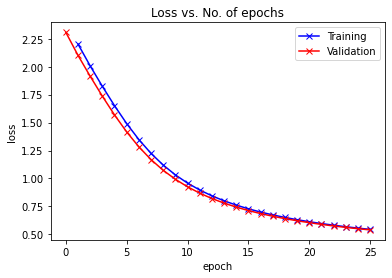

In [52]:
history = [result0] + history1 + history2 + history23 + history3 + history4

train_losses = [x.get('train_loss') for x in history]
val_losses = [x.get('val_loss') for x in history]
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs');

In [53]:
def predict_image(img, model):
  xb = img.unsqueeze(0)
  yb = model(xb)
  _, pred = torch.max(yb, dim=1)
  return train_set.classes[pred[0].item()]

torch.Size([1, 28, 28])
Label : 5 - five  Predicted :  5 - five


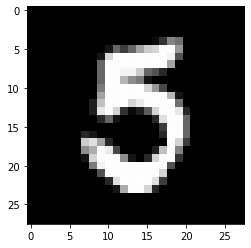

In [54]:

img, label = test_set[1089]
print(img.shape)
plt.imshow(img[0, :, :], cmap='gray')
print("Label :", train_set.classes[label], ' Predicted : ', predict_image(img, model))


torch.Size([1, 28, 28])
Label : 0 - zero  Predicted :  0 - zero


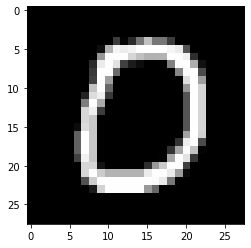

In [55]:
img, label = test_set[10]
print(img.shape)
plt.imshow(img[0, :, :], cmap='gray')
print("Label :", train_set.classes[label], ' Predicted : ', predict_image(img, model))


torch.Size([1, 28, 28])
Label : 6 - six  Predicted :  6 - six


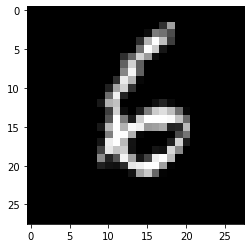

In [56]:
img, label = test_set[2000]
print(img.shape)

plt.imshow(img[0, :, :], cmap='gray')
print("Label :", train_set.classes[label], ' Predicted : ', predict_image(img, model))


In [59]:
torch.save(model.state_dict(), 'feed_forwardtan.pth')


In [60]:
model.load_state_dict(torch.load('feed_forwardtan.pth'))


<All keys matched successfully>

In [61]:
def output_label(label):
    output_mapping = {
                 0: "0",
                 1: "1",
                 2: "2",
                 3: "3",
                 4: "4", 
                 5: "5", 
                 6: "6",
                 7: "7",
                 8: "8",
                 9: "9"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [62]:
from torch.autograd import Variable
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_dl:
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of 0: 96.05%
Accuracy of 1: 95.56%
Accuracy of 2: 86.81%
Accuracy of 3: 91.78%
Accuracy of 4: 88.76%
Accuracy of 5: 79.41%
Accuracy of 6: 87.10%
Accuracy of 7: 86.42%
Accuracy of 8: 84.42%
Accuracy of 9: 85.54%


In [63]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = []
y_true = []

for inputs, labels in test_dl:
        output = model(inputs) 
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 

# constant for classes
classes = tuple([str(x) for x in range(10)])
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("Classification report for FNN :\n%s\n"
      % (classification_report(y_true, y_pred)))

Classification report for FNN :
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       980
           1       0.93      0.96      0.94      1135
           2       0.89      0.83      0.86      1032
           3       0.86      0.88      0.87      1010
           4       0.87      0.90      0.89       982
           5       0.87      0.77      0.82       892
           6       0.89      0.92      0.90       958
           7       0.90      0.88      0.89      1028
           8       0.83      0.83      0.83       974
           9       0.86      0.85      0.86      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


